In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import spacy
from tensorflow.keras.optimizers import Adadelta
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import gc

In [2]:
# read data saved in the previous notebook
train = pd.read_pickle('../input/longreview/train_review')
test = pd.read_pickle('../input/longreview/test_review')

In [3]:
nlp=spacy.load('en_core_web_lg', disable=['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner'])

In [4]:
%%time
#maximum length of reviews
def len_rev(data):
    leng={}
    for i, r in enumerate(data):
        leng.update({i:len(r.split(" "))})
    return leng


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.34 µs


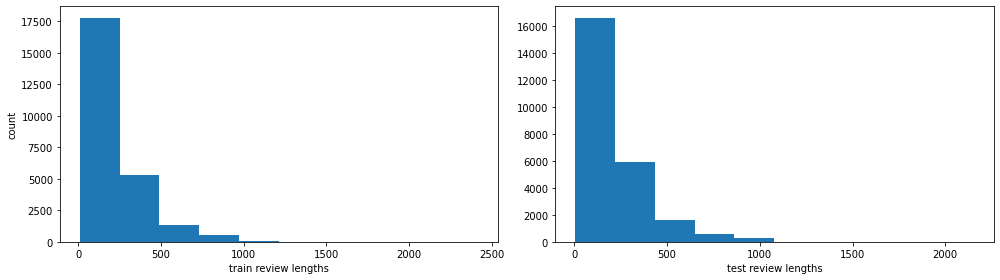

In [5]:
fig,ax=plt.subplots(1,2, figsize=(14,4))
ax[0].hist(len_rev(train.review).values())
ax[0].set_xlabel("train review lengths")
ax[0].set_ylabel("count")
ax[1].hist(len_rev(test.review).values())
ax[1].set_xlabel("test review lengths")
plt.tight_layout()
plt.show()

> reviews with length less than 300 words are the most common

In [6]:
maxl=300
#convert a review to a list of words, each word represented by a vector: output 2d array
def rev_2d_vec(review):
    emb_rev=[]
    for token in nlp(review):
        emb_rev.append(token.vector)
    a=np.array(emb_rev)
    a.resize(maxl,300)  # pad with zero when having lower shape
    a=(a-a.mean())/a.std()
    return  a 

class datagen:
    def __init__(self, x,y=None):
        self.x=x
        self.y=y
        
    def __call__(self):
        if self.y is None:
            for review in self.x:
                yield rev_2d_vec(review)
        else:
            for review, sentiment in zip(self.x,self.y):
                yield rev_2d_vec(review), sentiment
        

In [7]:
# del model
tf.keras.backend.clear_session()
gc.collect()
def get_model():
    inputs=tf.keras.Input(shape=(maxl,300))
    x=tf.keras.layers.Reshape((maxl,300,1))(inputs)
    x=tf.keras.layers.Conv2D(32, 8, padding='valid', activation='relu')(x)
    x=tf.keras.layers.MaxPooling2D()(x)
    x=tf.keras.layers.Conv2D(64, 8, padding='valid', activation='relu')(x)
    x=tf.keras.layers.MaxPooling2D()(x)
    x=tf.keras.layers.Flatten()(x)
    x=tf.keras.layers.Dropout(0.5)(x)
    x=tf.keras.layers.Dense(128, activation='relu')(x)
    outputs=tf.keras.layers.Dense(1, "sigmoid")(x)
    model = tf.keras.Model(inputs, outputs)
    opt = Adadelta(learning_rate=0.01, rho=0.95, epsilon=1e-6)
    model.compile(optimizer=opt,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy',tf.keras.metrics.AUC()])
    return model
model=get_model()
model.summary()

2022-09-12 11:14:39.238563: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300)]        0         
_________________________________________________________________
reshape (Reshape)            (None, 300, 300, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 293, 293, 32)      2080      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 146, 146, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 139, 139, 64)      131136    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 69, 69, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 304704)            0     

2022-09-12 11:14:39.239804: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-12 11:14:39.240508: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-12 11:14:39.241298: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-12 11:14:39.241618: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [8]:
epochs=20
batch_size=128


# checkpoints = tf.keras.callbacks.ModelCheckpoint('/tmp/checkpoint',
#                                                  monitor='val_auc',
#                                                  mode="max",
#                                                  verbose=1,
#                                                  save_best_only=True,
#                                                  save_weights_only=True)

# earlystop = tf.keras.callbacks.EarlyStopping(
#     monitor='val_auc',
#     min_delta=0,
#     patience=4,
#     verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)


In [9]:
%%time
# prepare data
xtrain,xtest,ytrain,ytest=train_test_split(train.review,train.sentiment, test_size=0.2, stratify= train.sentiment)

train_ds = tf.data.Dataset.from_generator(datagen(xtrain, ytrain),output_signature=(tf.TensorSpec(shape=(maxl,300),dtype=tf.float32),
                                                                          tf.TensorSpec(shape=(), dtype=tf.int32))).batch(batch_size)

test_ds = tf.data.Dataset.from_generator(datagen(xtest, ytest),output_signature=(tf.TensorSpec(shape=(maxl,300),dtype=tf.float32),
                                                                          tf.TensorSpec(shape=(), dtype=tf.int32))).batch(batch_size)


history = model.fit(train_ds,validation_data=test_ds, epochs=epochs, callbacks=[reduce_lr])

Epoch 1/20


2022-09-12 11:14:48.153948: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-09-12 11:14:50.107774: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


157/157 [==============================] - 99s 562ms/step - loss: 0.7029 - accuracy: 0.5153 - auc: 0.5198 - val_loss: 0.6908 - val_accuracy: 0.5400 - val_auc: 0.5508
Epoch 2/20
157/157 [==============================] - 80s 508ms/step - loss: 0.6872 - accuracy: 0.5457 - auc: 0.5630 - val_loss: 0.6891 - val_accuracy: 0.5112 - val_auc: 0.6460
Epoch 3/20
157/157 [==============================] - 81s 516ms/step - loss: 0.6650 - accuracy: 0.5992 - auc: 0.6421 - val_loss: 0.6615 - val_accuracy: 0.5538 - val_auc: 0.7501
Epoch 4/20
157/157 [==============================] - 80s 509ms/step - loss: 0.6196 - accuracy: 0.6603 - auc: 0.7234 - val_loss: 0.6361 - val_accuracy: 0.6094 - val_auc: 0.8052
Epoch 5/20
157/157 [==============================] - 80s 512ms/step - loss: 0.5657 - accuracy: 0.7100 - auc: 0.7829 - val_loss: 0.5768 - val_accuracy: 0.6882 - val_auc: 0.8343
Epoch 6/20
157/157 [==============================] - 80s 510ms/step - loss: 0.5190 - accuracy: 0.7448 - auc: 0.8242 - val_los

In [10]:
# cross validation

kf=KFold(n_splits=5)
i=1
cv_perf={}
for tr_idx, ts_idx in kf.split(xtrain):
    print(f"======================== Fold {i} =============================")
    model=get_model()
    train_ds = tf.data.Dataset.from_generator(datagen(xtrain.iloc[tr_idx], ytrain.iloc[tr_idx]),
                                              output_signature=(tf.TensorSpec(shape=(maxl,300),dtype=tf.float32),
                                                                tf.TensorSpec(shape=(), dtype=tf.int32))).batch(batch_size)

    val_ds = tf.data.Dataset.from_generator(datagen(xtrain.iloc[ts_idx], ytrain.iloc[ts_idx]),
                                            output_signature=(tf.TensorSpec(shape=(maxl,300),dtype=tf.float32),
                                                              tf.TensorSpec(shape=(), dtype=tf.int32))).batch(batch_size)
    
    cvhistory = model.fit(train_ds,validation_data=val_ds, epochs=epochs, callbacks=[reduce_lr])
    cv_perf.update({f"fold_{i}":cvhistory.history})
    i+=1
    del model
    tf.keras.backend.clear_session()
    gc.collect()
    print("\n")

======================== Fold 1 =============================
Epoch 1/20
125/125 [==============================] - 63s 497ms/step - loss: 0.7033 - accuracy: 0.5174 - auc_1: 0.5242 - val_loss: 0.6930 - val_accuracy: 0.5170 - val_auc_1: 0.5510
Epoch 2/20
125/125 [==============================] - 61s 488ms/step - loss: 0.6848 - accuracy: 0.5451 - auc_1: 0.5714 - val_loss: 0.6684 - val_accuracy: 0.6315 - val_auc_1: 0.6825
Epoch 3/20
125/125 [==============================] - 64s 513ms/step - loss: 0.6597 - accuracy: 0.6096 - auc_1: 0.6526 - val_loss: 0.6283 - val_accuracy: 0.6875 - val_auc_1: 0.7644
Epoch 4/20
125/125 [==============================] - 64s 511ms/step - loss: 0.6183 - accuracy: 0.6611 - auc_1: 0.7235 - val_loss: 0.5960 - val_accuracy: 0.6670 - val_auc_1: 0.8129
Epoch 5/20
125/125 [==============================] - 64s 515ms/step - loss: 0.5722 - accuracy: 0.7039 - auc_1: 0.7761 - val_loss: 0.5832 - val_accuracy: 0.6727 - val_auc_1: 0.8418
Epoch 6/20
125/125 [=============

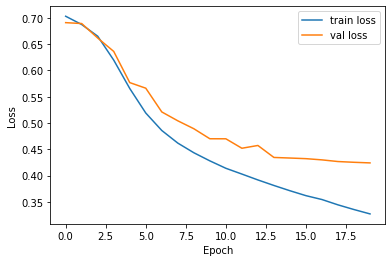

In [11]:
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

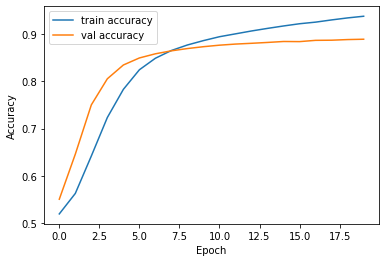

In [12]:
plt.plot(history.history["auc"], label="train accuracy")
plt.plot(history.history["val_auc"], label="val accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
# submission

# sub_ds = tf.data.Dataset.from_generator(datagen(test.review), output_signature=(tf.TensorSpec(shape=(maxl,300),dtype=tf.float32))).batch(batch_size)
# pred=model.predict(sub_ds)
# pred_class=np.where(pred>0.5,1,0).reshape(-1)
# pd.DataFrame({"id":test.id.values, "sentiment":pred_class}).to_csv('submission.csv', header=True, index=False)